# Exploration and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
try: 
    import emoji
except ImportError:
    !pip install emoji --user
    import emoji
    
try:
    from bs4 import BeautifulSoup 
except:
    !pip install bs4 --user
    from bs4 import BeautifulSoup
from tqdm.autonotebook import  tqdm
tqdm.pandas()

try:
    import nltk
    #raise Exception
except:
    !pip install nltk --user
    import nltk
    nltk.download('punkt')
    
try:
    import textblob
except:
    !pip install textblob --user
    import textblob


import re

pd.__version__

/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


'0.25.3'

### Dropping Duplicates and NaN

In [2]:
# raw data loading

df = pd.read_csv("../data/meetup.csv")
df.head()

,description,status,event_id,event_name,category
0,<p>FOOD AND FELLOWSHIP | 5 PM</p> \n<p>CONCERT...,upcoming,239660020,We Are Messengers Concert,singles
1,<p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...,upcoming,239719229,Friendly Friday!!,socializing
2,<p>TENTATIVE<br></p>\n<p><br></p>\n<p>10.30 - ...,upcoming,239691981,Ansible meetup,tech
3,"<p><span>Hey explorersssss, what's up?</span><...",upcoming,239719250,Secret spot for Hong Kong night view + food ad...,language/ethnic identity
4,"<p>Free, unauditioned, collaborative pop choir...",deleted,gpjktmywhbnb,Come and sing with us!,music


In [3]:
# removing useless columns

df.drop(columns = ["status"], inplace=True)

In [4]:
# some NaN in the category and description series, 

df.isna().any(),\
df[ df.category.isna() | df.description.isna() ].shape[0], \
df.shape[0] -df[ df.category.isna() | df.description.isna() ].shape[0],\
df.dropna().shape

(description     True
 event_id       False
 event_name     False
 category        True
 dtype: bool, 15436, 179883, (179883, 4))

In [5]:
df.dropna(inplace=True)
df.shape

(179883, 4)

In [6]:
# some events are duplicated during the streaming

df.event_id.unique().shape, df.shape, df[df.event_id == "239660020"].description

((134207,),
 (179883, 4),
 0         <p>FOOD AND FELLOWSHIP | 5 PM</p> \n<p>CONCERT...
 180285    <p>FOOD AND FELLOWSHIP | 5 PM</p>\n<p>CONCERT ...
 Name: description, dtype: object)

In [7]:
# removing duplicate events keeping only the last description (i.e. the last modification of the event description)

df.drop_duplicates(subset="event_id", keep = "last", inplace=True)
df.shape

(134207, 4)

(socializing                 13498
 health/wellbeing            13349
 career/business             12322
 outdoors/adventure          11977
 tech                        11739
 new age/spirituality         8519
 sports/recreation            7005
 fitness                      6842
 language/ethnic identity     5689
 games                        4156
 food/drink                   3673
 dancing                      3555
 fine arts/culture            3177
 music                        2659
 education/learning           2626
 movements/politics           2604
 community/environment        2404
 religion/beliefs             2287
 singles                      2159
 parents/family               2010
 hobbies/crafts               1584
 photography                  1452
 movies/film                  1279
 support                      1169
 writing                      1080
 LGBT                         1071
 book clubs                   1011
 cars/motorcycles              917
 pets/animals       

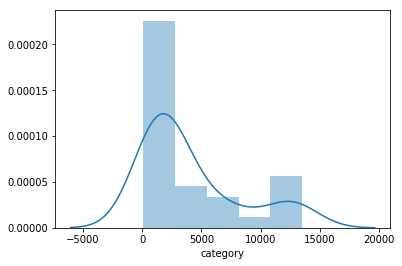

In [8]:
# value count of categories

df.category.value_counts(), \
sns.distplot(df.category.value_counts())

In [9]:
# removing paranormal category: under-represented

df = df[df.category !="paranormal"]
df.shape, df.category.value_counts()

((134125, 4), socializing                 13498
 health/wellbeing            13349
 career/business             12322
 outdoors/adventure          11977
 tech                        11739
 new age/spirituality         8519
 sports/recreation            7005
 fitness                      6842
 language/ethnic identity     5689
 games                        4156
 food/drink                   3673
 dancing                      3555
 fine arts/culture            3177
 music                        2659
 education/learning           2626
 movements/politics           2604
 community/environment        2404
 religion/beliefs             2287
 singles                      2159
 parents/family               2010
 hobbies/crafts               1584
 photography                  1452
 movies/film                  1279
 support                      1169
 writing                      1080
 LGBT                         1071
 book clubs                   1011
 cars/motorcycles              917
 pets/a

In [10]:
# after a first classification attempt, blablabla FIXME
# mapping fashion/beauty -> health/wellbeing,
#         alternative lifestyle -> new age/spirituality
#print(df.category.unique().shape)
#df["category"] = df.category.map(lambda x: "health/wellbeing" if x == "fashion/beauty" else x)
#df["category"] = df.category.map(lambda x: "new age/spirituality" if x == "alternative lifestyle" else x)
#df["category"] = df.category.map(lambda x: "sci-fi/fantasy" if x == "alternative lifestyle" else x)

print(df.category.unique().shape)


#df.category.value_counts()

(32,)


In [11]:
# label encoding the category for better representation 
from sklearn.preprocessing import LabelEncoder

df.reset_index(drop=True, inplace=True)
le = LabelEncoder()

df["category_label"] = le.fit_transform(df.category)

### HTML tags removal & emoji stripping

In [12]:
# html tag removal
 

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

df["desc_no_html"]= df.description.progress_map(lambda x :BeautifulSoup(x,"lxml").text)

A Jupyter Widget

In [13]:
# concatenate event name to the description

df["desc_no_html"] = df.event_name + " " + df.desc_no_html

In [14]:
# link removal via regex

import re
df["desc_no_html_no_link"] = df.desc_no_html.progress_map(lambda x:  re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

A Jupyter Widget

In [15]:

def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

    return clean_text

df["desc_no_html_no_link_no_emoji"] = df.desc_no_html_no_link.progress_map(give_emoji_free_text)

A Jupyter Widget

In [16]:
#with open("../data/df_no_html_no_link_no_emoji.pckl", "wb") as outf:
#    pickle.dump(df, outf)

In [17]:
#with open("../data/df_no_html_no_link_no_emoji.pckl", "rb") as inf:
#    df = pickle.load(inf)

In [18]:
df.head()

,description,event_id,event_name,category,category_label,desc_no_html,desc_no_html_no_link,desc_no_html_no_link_no_emoji
0,"<p><span>Hey explorersssss, what's up?</span><...",239719250,Secret spot for Hong Kong night view + food ad...,language/ethnic identity,15,Secret spot for Hong Kong night view + food ad...,Secret spot for Hong Kong night view + food ad...,Secret spot for Hong Kong night view + food ad...
1,"<p>Free, unauditioned, collaborative pop choir...",gpjktmywhbnb,Come and sing with us!,music,18,"Come and sing with us! Free, unauditioned, col...","Come and sing with us! Free, unauditioned, col...","Come and sing with us! Free, unauditioned, col..."
2,"<p>We provide a forum to learn about, promote ...",drrtzmywhbgb,East Valley Business Network Meetup,career/business,3,East Valley Business Network Meetup We provide...,East Valley Business Network Meetup We provide...,East Valley Business Network Meetup We provide...
3,<p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...,239719229,Friendly Friday!!,socializing,27,Friendly Friday!! 【WhyNot!?JAPAN + MeetUp Coll...,Friendly Friday!! 【WhyNot!?JAPAN + MeetUp Coll...,Friendly Friday!! 【WhyNot!?JAPAN + MeetUp Coll...
4,<p>This is an introductory meeting to get to k...,mtzxwmywjbjb,Authentication options,tech,30,Authentication options This is an introductory...,Authentication options This is an introductory...,Authentication options This is an introductory...


### Language Detection and Language Selection

In [20]:
server = True
if not server:
    try:
        from polyglot.detect import Detector
    except ImportError:
        #!pip install --user pyicu pycld2
        !pip install polyglot --user

        from polyglot.detect import Detector


    df["lang"] = "NaN"

    def detect_lang(text):
        try:
            lang = Detector(text, quiet=True)
            if lang.reliable:
                return lang.language.name  if lang.language.confidence > 50 else "low_conf"
            else: 
                return "not_reliable"
        except Exception as e: 
            return "error"

    def detect_lang_reliab(text):
        try:
            lang = Detector(text, quiet=True)
            if lang.reliable:
                return lang.language.confidence
            else: 
                return "not_reliable"
        except Exception as e: 
            return "error"

    df["lang"] = df.desc_no_html_no_link_no_emoji.progress_map(detect_lang)

    df["lang_reliab"] = df.desc_no_html_no_link_no_emoji.progress_map(detect_lang_reliab)

    df.lang.value_counts()

    #with open("df_no_html_no_link_no_emoji_lang.pckl", "wb") as outf:
    #    pickle.dump(df, outf)
    
else:
    #with open("../data/backup/df_no_html_no_link_no_emoji_lang.pckl", "rb") as inf:
    #    df_lang = pickle.load(inf)

    #df["lang"] = df_lang.lang
    #df["lang_reliab"] = df_lang.lang_reliab
    pass

In [21]:
df.head()

,description,event_id,event_name,category,category_label,desc_no_html,desc_no_html_no_link,desc_no_html_no_link_no_emoji,lang,lang_reliab
0,"<p><span>Hey explorersssss, what's up?</span><...",239719250,Secret spot for Hong Kong night view + food ad...,language/ethnic identity,15,Secret spot for Hong Kong night view + food ad...,Secret spot for Hong Kong night view + food ad...,Secret spot for Hong Kong night view + food ad...,English,99
1,"<p>Free, unauditioned, collaborative pop choir...",gpjktmywhbnb,Come and sing with us!,music,18,"Come and sing with us! Free, unauditioned, col...","Come and sing with us! Free, unauditioned, col...","Come and sing with us! Free, unauditioned, col...",English,99
2,"<p>We provide a forum to learn about, promote ...",drrtzmywhbgb,East Valley Business Network Meetup,career/business,3,East Valley Business Network Meetup We provide...,East Valley Business Network Meetup We provide...,East Valley Business Network Meetup We provide...,English,98
3,<p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...,239719229,Friendly Friday!!,socializing,27,Friendly Friday!! 【WhyNot!?JAPAN + MeetUp Coll...,Friendly Friday!! 【WhyNot!?JAPAN + MeetUp Coll...,Friendly Friday!! 【WhyNot!?JAPAN + MeetUp Coll...,English,92
4,<p>This is an introductory meeting to get to k...,mtzxwmywjbjb,Authentication options,tech,30,Authentication options This is an introductory...,Authentication options This is an introductory...,Authentication options This is an introductory...,English,99


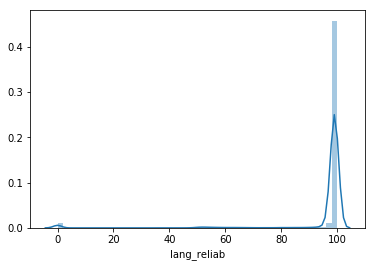

In [22]:
sns.distplot(df.lang_reliab.apply(lambda x :float(x) if x != "not_reliable" and x != "error" else 0))

In [23]:
print(df.shape)
df = df[df.lang == "English"]
df.shape

(134125, 10)


(120809, 10)

In [24]:
df[df.lang_reliab > 50].shape

(120809, 10)

### Punctuation removal

In [46]:
import string
#nltk.download('stopwords') #first usage
#my_punct = string.punctuation.replace("'","")
europ_languages = ["english", 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'portuguese', 'russian', 'spanish', 'swedish', 'turkish']
#europ_languages = ["english"]
#europ_languages=nltk.corpus.stopwords.fileids()
#europ_languages

   
stopwords = set(nltk.corpus.stopwords.words(europ_languages))                  
stemmer =  nltk.PorterStemmer()

In [47]:
len(stopwords)

2146

In [51]:
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict

text = df.desc_no_html_no_link_no_emoji[0]
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

#text = "Another way of achieving this task"
#tokens = word_tokenize(text)
lemmatizer = WordNetLemmatizer()

def remove_punct_and_normalize(text, no_tokens, Stemmer, tag_map, lemmatizer, badwords = None, remove_badwords = False, stemm = True, lemm = False):
    text = text.replace("'s ", " ")
    tokens = re.sub("[^a-zA-Z]", " ", text).lower().split( ) #.replace("|","").replace("!","").replace("?","")
    if not remove_badwords:
        no_stop_tokens = [token for token in tokens if token not in no_tokens]
    else:
        no_stop_tokens = [token for token in tokens if all([token not in no_tokens, token not in bad_words])] 
    
    if stemm:
        stemmed = [Stemmer.stem(elem) for elem in no_stop_tokens]
        if remove_badwords:
            stemmed = [elem for elem in stemmed if elem not in bad_words] #badwords after stemming
        return( " ".join(stemmed))
    elif lemm:
        lemmed = [lemmatizer.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(no_stop_tokens)]
        if remove_badwords:
            lemmed = [elem for elem in lemmed if elem not in bad_words] #badwords after stemming
        return (" ".join(lemmed))
    else:
        print("yolo")
        raise NotImplementedError

from multiprocessing import cpu_count, Pool

def parallelize(data, func, n_cores):
    data_split = np.array_split(data, n_cores)
    pool = Pool(n_cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data
#df["yolo"]="NaN"
def lemmatization(data):
    #print "Process working on: ",data
    data["desc_lemm"] = data.desc_no_html_no_link_no_emoji.progress_map(lambda x: remove_punct_and_normalize(x, stopwords, stemmer, tag_map, lemmatizer, stemm = False, lemm = True))
    return data

def stemming(data):
    #print "Process working on: ",data
    data["desc_stemm"] = data.desc_no_html_no_link_no_emoji.progress_map(lambda x: remove_punct_and_normalize(x, stopwords, stemmer, tag_map, lemmatizer, stemm = True, lemm = False))
    return data

In [49]:
%%time
df = parallelize(df, stemming, n_cores = 40)









































CPU times: user 3.51 s, sys: 6.69 s, total: 10.2 s
Wall time: 45 s


In [61]:
%%time
df = parallelize(df, lemmatization, n_cores = 40)









































CPU times: user 6.04 s, sys: 16.9 s, total: 22.9 s
Wall time: 1min 49s


# Cleansing After LDA Clustering 

## (removing "garbage" cluster)

In [69]:
# recurrent "badwords" identified by LDA clustering
bad_words=[
    "www", "http", "https", "th", "pm", "ticket", "org", "event", "link", "registr", "hi", "oil", "en", "lo", "ca", 
    "month", "monday", "tuesday", "wednesday", "thursday","friday", "saturday", "sunday",
    "meetup","meetups", "meet","area","happen", "event", "group", "regist", "pleas", "please", "join", "rsvp", "member", "mask", 
    "venu", "free", "comment", "thank", "attend", "eventbrit", "mr", "st", "rd", "hour", "mask", "locat", "everyone", "everyon", "contact", "anyone", "great",
    "new", "time", "stand", "host", "check", "line", "com", "fee", "cost", "people", "day", "new", "know", "inform", "email", "bring","welcome", "welcom",
    "boston", "like", "la", "en", "los", "come", "let", "facebook", "available",  "help", "look", "register", "sign","registration",  ]
len(bad_words), len(set(bad_words)) #woops

(86, 82)

In [70]:
def lemmatization_badwords(data):
    #print "Process working on: ",data
    data["desc_lemm_no_badwords"] = data.desc_no_html_no_link_no_emoji.progress_map(lambda x: remove_punct_and_normalize(x, stopwords, stemmer, tag_map, lemmatizer, badwords=bad_words, remove_badwords=True, stemm = False, lemm = True))
    return data

def stemming_badwords(data):
    #print "Process working on: ",data
    data["desc_stemm_no_badwords"] = data.desc_no_html_no_link_no_emoji.progress_map(lambda x: remove_punct_and_normalize(x, stopwords, stemmer, tag_map, lemmatizer,  badwords=bad_words, remove_badwords=True, stemm = True, lemm = False))
    return data

In [71]:
df.tail()

,description,event_id,event_name,category,category_label,desc_no_html,desc_no_html_no_link,desc_no_html_no_link_no_emoji,lang,lang_reliab,desc_stemm,desc_lemm,desc_stemm_no_badwords,desc_lemm_no_badwords
134120,<p>Shuttlecats is a new badminton group for qu...,239775649,SHUTTLECATS badminton session (meet at court 1),fitness,10,SHUTTLECATS badminton session (meet at court 1...,SHUTTLECATS badminton session (meet at court 1...,SHUTTLECATS badminton session (meet at court 1...,English,99,shuttlecat badminton session meet court shuttl...,shuttlecats badminton session meet court shutt...,shuttlecat badminton session court shuttlecat ...,shuttlecats badminton session court shuttlecat...
134121,<p>Gathering the Tribe of Lightworkers/Energy ...,239775650,Lightworkers Unite,new age/spirituality,19,Lightworkers Unite Gathering the Tribe of Ligh...,Lightworkers Unite Gathering the Tribe of Ligh...,Lightworkers Unite Gathering the Tribe of Ligh...,English,99,lightwork unit gather tribe lightwork energi h...,lightworkers unite gather tribe lightworkers e...,lightwork unit gather tribe lightwork energi h...,lightworkers unite gather tribe lightworkers e...
134122,"<p>I am hosting an event, and would like to in...",239775613,BREAKTHROUGH TO SUCCESS EVENT,career/business,3,BREAKTHROUGH TO SUCCESS EVENT I am hosting an ...,BREAKTHROUGH TO SUCCESS EVENT I am hosting an ...,BREAKTHROUGH TO SUCCESS EVENT I am hosting an ...,English,99,breakthrough success event host event would li...,breakthrough success event host event would li...,breakthrough success would invit along list si...,breakthrough success would invite along list s...
134123,"<p><img src=""https://secure.meetupstatic.com/p...",239775232,Great Glarus Hike,outdoors/adventure,20,"Great Glarus Hike \nDear All,\nThe plan is to ...","Great Glarus Hike \nDear All,\nThe plan is to ...","Great Glarus Hike Dear All, The plan is to hav...",English,99,great glaru hike dear plan fantast hike glaru ...,great glarus hike dear plan fantastic hike gla...,great glaru hike dear plan fantast hike glaru ...,great glarus hike dear plan fantastic hike gla...
134124,<p>Travel two miles north of Concord Hospital....,239599549,Hike Trails from Carter Hill Orchard to Swope ...,outdoors/adventure,20,Hike Trails from Carter Hill Orchard to Swope ...,Hike Trails from Carter Hill Orchard to Swope ...,Hike Trails from Carter Hill Orchard to Swope ...,English,99,hike trail carter hill orchard swope back trav...,hike trail carter hill orchard swope back trav...,hike trail carter hill orchard swope back trav...,hike trail carter hill orchard swope back trav...


In [72]:
%%time
df = parallelize(df, stemming_badwords, n_cores = 40)









































CPU times: user 4.97 s, sys: 14.9 s, total: 19.8 s
Wall time: 53.8 s


In [73]:
%%time
df = parallelize(df, lemmatization_badwords, n_cores = 40)









































CPU times: user 5.24 s, sys: 16.2 s, total: 21.4 s
Wall time: 1min 33s


In [74]:
df.tail()

,description,event_id,event_name,category,category_label,desc_no_html,desc_no_html_no_link,desc_no_html_no_link_no_emoji,lang,lang_reliab,desc_stemm,desc_lemm,desc_stemm_no_badwords,desc_lemm_no_badwords
134120,<p>Shuttlecats is a new badminton group for qu...,239775649,SHUTTLECATS badminton session (meet at court 1),fitness,10,SHUTTLECATS badminton session (meet at court 1...,SHUTTLECATS badminton session (meet at court 1...,SHUTTLECATS badminton session (meet at court 1...,English,99,shuttlecat badminton session meet court shuttl...,shuttlecats badminton session meet court shutt...,shuttlecat badminton session court shuttlecat ...,shuttlecats badminton session court shuttlecat...
134121,<p>Gathering the Tribe of Lightworkers/Energy ...,239775650,Lightworkers Unite,new age/spirituality,19,Lightworkers Unite Gathering the Tribe of Ligh...,Lightworkers Unite Gathering the Tribe of Ligh...,Lightworkers Unite Gathering the Tribe of Ligh...,English,99,lightwork unit gather tribe lightwork energi h...,lightworkers unite gather tribe lightworkers e...,lightwork unit gather tribe lightwork energi h...,lightworkers unite gather tribe lightworkers e...
134122,"<p>I am hosting an event, and would like to in...",239775613,BREAKTHROUGH TO SUCCESS EVENT,career/business,3,BREAKTHROUGH TO SUCCESS EVENT I am hosting an ...,BREAKTHROUGH TO SUCCESS EVENT I am hosting an ...,BREAKTHROUGH TO SUCCESS EVENT I am hosting an ...,English,99,breakthrough success event host event would li...,breakthrough success event host event would li...,breakthrough success would invit along list si...,breakthrough success would invite along list s...
134123,"<p><img src=""https://secure.meetupstatic.com/p...",239775232,Great Glarus Hike,outdoors/adventure,20,"Great Glarus Hike \nDear All,\nThe plan is to ...","Great Glarus Hike \nDear All,\nThe plan is to ...","Great Glarus Hike Dear All, The plan is to hav...",English,99,great glaru hike dear plan fantast hike glaru ...,great glarus hike dear plan fantastic hike gla...,glaru hike dear plan fantast hike glaru region...,glarus hike dear plan fantastic hike glarus re...
134124,<p>Travel two miles north of Concord Hospital....,239599549,Hike Trails from Carter Hill Orchard to Swope ...,outdoors/adventure,20,Hike Trails from Carter Hill Orchard to Swope ...,Hike Trails from Carter Hill Orchard to Swope ...,Hike Trails from Carter Hill Orchard to Swope ...,English,99,hike trail carter hill orchard swope back trav...,hike trail carter hill orchard swope back trav...,hike trail carter hill orchard swope back trav...,hike trail carter hill orchard swope back trav...


In [75]:
df_drop = df.drop(columns = ["event_name", "desc_no_html", "desc_no_html_no_link", "desc_no_html_no_link_no_emoji" ])
df_drop.head()

,description,event_id,category,category_label,lang,lang_reliab,desc_stemm,desc_lemm,desc_stemm_no_badwords,desc_lemm_no_badwords
0,"<p><span>Hey explorersssss, what's up?</span><...",239719250,language/ethnic identity,15,English,99,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...,secret spot hong kong night view food adventur...
1,"<p>Free, unauditioned, collaborative pop choir...",gpjktmywhbnb,music,18,English,99,sing us free unaudit collabor pop choir identi...,sing u free unauditioned collaborative pop cho...,sing us unaudit collabor pop choir identifi wo...,sing u unauditioned collaborative pop choir id...
2,"<p>We provide a forum to learn about, promote ...",drrtzmywhbgb,career/business,3,English,98,east valley busi network meetup provid forum l...,east valley business network meetup provide fo...,east valley busi network provid forum learn pr...,east valley business network provide forum lea...
3,<p><b>【WhyNot!?JAPAN + MeetUp Collaboration Ev...,239719229,socializing,27,English,92,friendli friday whynot japan meetup collabor e...,friendly friday whynot japan meetup collaborat...,friendli whynot japan collabor whynot japan si...,friendly whynot japan collaboration whynot jap...
4,<p>This is an introductory meeting to get to k...,mtzxwmywjbjb,tech,30,English,99,authent option introductori meet get know fell...,authentication option introductory meet get kn...,authent option introductori get fellow coder s...,authentication option introductory get fellow ...


In [76]:
df_drop.to_pickle("../data/df_preprocessed_eng.pckle")